# UK Fisheries

This project seeks to analyse data from the UK's fishing industry covering the period 2008-2023, looking primarily at landings data.  The term 'landings' refers to the weight and value of fish that is brought to land after being captured at sea, and is provided within the original datasets in both tonnes and GBP (£).  Data from 2024 has not been included to avoid skewing overall statistics.  

Some key questions that will be answered within this notebook are:

* Which ports are seeing the highest landings?
* Which countries are landing into the UK and how do their landings compare?
* Which ports are non-UK vessels primarily landing into?
* How do the landings vary by vessel category over the study period?

## Importing data and libraries
Firstly, let's import the libraries that we will need to run this analysis.

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import pearsonr
import os

Then the data - normally I much prefer smaller and more consistent filenames, but I decided to keep them as they were labelled on the government website just in case anyone wanted to track them down, so they could know they were using the same files.  This is with the exception of 2020, which I took from a longer dataset (2016-2020) so I labelled differently.

In [3]:
# Loading the data came with a few difficulties, so I needed to use the 'unicode_escape' argument as there was a non-ascii character in the dictionary.
data_2008 = pd.read_csv('./data/UK_fleet_landings_and_foreign_fleet_landings_into_the_UK_by_port_2008.csv', encoding='unicode_escape')
data_2009 = pd.read_csv('./data/UK_fleet_landings_and_foreign_fleet_landings_into_the_UK_by_port_2009.csv', encoding='unicode_escape')
data_2010 = pd.read_csv('./data/UK_fleet_landings_and_foreign_fleet_landings_into_the_UK_by_port_2010.csv', encoding='unicode_escape')
data_2011 = pd.read_csv('./data/UK_fleet_landings_and_foreign_fleet_landings_into_the_UK_by_port_2011.csv', encoding='unicode_escape')
data_2012 = pd.read_csv('./data/UK_fleet_landings_and_foreign_fleet_landings_into_the_UK_by_port_2012.csv', encoding='unicode_escape')
data_2013 = pd.read_csv('./data/UK_fleet_landings_and_foreign_fleet_landings_into_the_UK_by_port_2013.csv', encoding='unicode_escape')
data_2014 = pd.read_csv('./data/UK_fleet_landings_and_foreign_fleet_landings_into_the_UK_by_port_2014.csv', encoding='unicode_escape')
data_2015 = pd.read_csv('./data/UK_fleet_landings_and_foreign_fleet_landings_into_the_UK_by_port_2015.csv', encoding='unicode_escape')
data_2016 = pd.read_csv('./data/UK_fleet_landings_and_foreign_fleet_landings_into_the_UK_by_port_2016.csv', encoding='unicode_escape')
data_2017 = pd.read_csv('./data/UK_fleet_landings_and_foreign_fleet_landings_into_the_UK_by_port_2017.csv', encoding='unicode_escape')
data_2018 = pd.read_csv('./data/UK_fleet_landings_and_foreign_fleet_landings_into_the_UK_by_port_2018.csv', encoding='unicode_escape')
data_2019 = pd.read_csv('./data/UK_fleet_landings_and_foreign_fleet_landings_into_the_UK_by_port_2019.csv', encoding='unicode_escape')
data_2020 = pd.read_csv('./data/UK_and_foreign_landings_by_port_2020.csv', encoding='unicode_escape')
data_2021 = pd.read_csv('./data/Provisional_Dataset_UK_and_Foreign_Vessels_landings_by_UK_port_and_UK_vessel_landings_abroad_2021__year_to_date_.csv', encoding='unicode_escape')
data_2022 = pd.read_csv('./data/Provisional_Dataset_UK_and_Foreign_Vessels_landings_by_UK_port_and_UK_vessel_landings_abroad_2022__year_to_date_.csv', encoding='unicode_escape')
data_2023 = pd.read_csv('./data/Provisional_Dataset_UK_and_Foreign_Vessels_landings_by_UK_port_and_UK_vessel_landings_abroad_2023_year_to_date_new_1.csv', encoding='unicode_escape')

# Create a list of the dataframes for later use when comparing years
data_by_year = [data_2008, data_2009, data_2010, data_2011, data_2012, \
                data_2013, data_2014, data_2015, data_2016, data_2017, \
                data_2018, data_2019, data_2020, data_2021, data_2022, data_2023]

# Change column name 'Species' to 'Species Broad'
for dataframe in data_by_year:
    dataframe.rename(columns = {'Species': 'Species Broad'},inplace = True)

# Then merge the dataframes into one large dataframe to make it easier to handle
all_data = data_2008.merge(data_2009, how = 'outer').merge(data_2010, how = 'outer'). \
    merge(data_2011, how = 'outer').merge(data_2012, how = 'outer').merge(data_2013, how = 'outer'). \
    merge(data_2014, how = 'outer').merge(data_2015, how = 'outer').merge(data_2016, how = 'outer'). \
    merge(data_2017, how = 'outer').merge(data_2018, how = 'outer').merge(data_2019, how = 'outer'). \
    merge(data_2020, how = 'outer').merge(data_2021, how = 'outer').merge(data_2022, how = 'outer'). \
    merge(data_2023, how = 'outer')

## Data Cleaning
Understandably, over the 15 years of data collection, the naming and style of the columns has changed slightly over time.  There are also just over 1.25 million rows in the dataset, so there are a few discrepancies and errors (but surprisingly few given the size of the dataset).  Some changes to the data were made manually within excel, but some are much easier to fix within Python.  One of these is the naming of the species columns.  Different years of data have variations on 'species', 'species group', 'species as included in publication', 'species as included in publication tables' etc.  After making some changes to the column labels, I decided to standardise across the study period and where possible include (in order of level of detail):

* __Species Name__ (goes to the greatest level of detail in this dataset i.e. 'Crabs - Velvet (Swim))
* __Species Broad__ (goes to the second greatest level of detail i.e. 'Crabs')
* __Species Code__ (a three-letter code that corresponds to 'Species Broad' i.e. 'CRE')
* __Species Group__ (the lowest level of detail in this dataset i.e. 'Shellfish')

My preference would be to use the highest level of detail possible that can be gleaned for all years.  However, 2008 only includes the data to the level of 'Species Broad', so I'm using that.  Some years only include species name, so I will need to fill in the Species Broad value where this is missing, based on the Species Name.

In [4]:
# Create a cross-reference table
codes_names = all_data[['Species Code', 'Species Name', 'Species Broad']]
codes_names = codes_names.drop_duplicates().dropna()

## A couple of manual additions
# For 2021, the species code for red mullet was incorrectly recorded as 'MUT', it should be 'MUR', the line below replaces these values:
all_data['Species Code'] = all_data['Species Code'].replace('MUT', 'MUR')

# One species (Aesop shrimp) doesn't have a species broad value included at all - so I am adding this in manually:
missing_entry = pd.DataFrame({'Species Code': ['AES'], \
                              'Species Name': ['Aesop shrimp'],\
                              'Species Broad': ['Shrimps and Prawns']})

# Add this missing entry to the codes_names DataFrame
codes_names = pd.concat([codes_names, missing_entry], ignore_index=True)


# Define a function to fill missing 'Species Broad' values based on the corresponding 'Species Code' value within codes_names
def fill_species_broad(row, codes_names_df):
    if pd.isna(row['Species Broad']):  # Check if 'Species Broad' is missing
        # Look up the 'Species Broad' value in codes_names based on 'Species Code'
        species_code = row['Species Code']
        
        # Find the matching row in codes_names
        species_broad = codes_names_df.loc[codes_names_df['Species Code'] == species_code, 'Species Broad']
        
        # If a match is found, return the corresponding 'Species Broad' value, else leave as NaN
        if not species_broad.empty:
            return species_broad.values[0]
    return row['Species Broad']

# Apply the function to the all_data DataFrame
all_data['Species Broad'] = all_data.apply(lambda row: fill_species_broad(row, codes_names), axis=1)

print(all_data['Species Broad'].isna().sum()) 

14


I now only have 14 records missing a Species Broad value.  From a visual check of these using the Data Wrangler extension in VS Code, I can see that these are very unusual species that I believe to have been caught as by-catch.  They include things like sharks, lanternfish and jellyfish.  I am happy to leave them in and ignore these datapoints.  

While the data is now in the appropriate columns, I can see that some of the data entries have a negative value recorded against the tonnes and GBP of landings.  Obviously this isn't possible, and I'm unsure of the reason as for the error in these lines.  As a result, I need to perform listwise deletion to remove the entire observation for each where the value is negative.  As there are not many, I am not concerned about the overall impact to the data (there's no hard and fast rule, but in general, under 5% loss is considered to be acceptable). 

In [5]:
negative_count = (all_data['Value (£)'] < 0).sum() + (all_data['Landed Weight (tonnes)'] < 0).sum()
print(negative_count)

negative_pc = (negative_count/len(all_data))*100
print('The percentage of data that will be deleted by removing observations with a negative landing weight or monetary value is',str(round(negative_pc,4)),'%')

17
The percentage of data that will be deleted by removing observations with a negative landing weight or monetary value is 0.0013 %


In [6]:
# Remove any lines that have negative weight or monetary values
# Define the three columns to check for negative values
columns_to_check = ['Live Weight (tonnes)', 'Landed Weight (tonnes)', 'Value (£)']

# Filter rows where all values in the specified columns are non-negative
all_data = all_data.loc[(all_data[columns_to_check] >= 0).all(axis=1)]

negative_count = (all_data['Value (£)'] < 0).sum() + (all_data['Landed Weight (tonnes)'] < 0).sum()
print(negative_count)

0


## Data Analysis and Presentation
Now the data has been tidied, standardised, and errors have been removed, it's time to start plotting up some of the data to see what it can tell us about the changes over the last 16 years.

### Which species have the greatest landings by weight and value?
The first thing I'd like to take a look at is the species that have the greatest landings.  As the value of a species can vary dramatically, I'd like to see how this compares between weight and monetary values.  I want to look at this overall, but eventually I'd also like to break this down by year and how the most popular species landed have varied over the time period.

In [7]:
# Create a dataframe of the sum and mean values per species for all years
allyears_agg_value= all_data.groupby(['Species Broad'])['Value (£)'].agg(['sum', 'mean']).reset_index()

# Rename columns for clarity
allyears_agg_value.columns = 'species_broad','total_value','average_value'

# Sort the species by the total value landed
sorted_species_value = allyears_agg_value.sort_values(by = 'total_value', ascending = False)

# Select the top 10 species
top_10_species_value = sorted_species_value.head(10).copy()

#  As the numbers are very large, I'm going to add a new columne where the value is 000's of pounds
top_10_species_value.loc[:,'total_value_000s'] = top_10_species_value.loc[:,'total_value']/1000

# Format the numbers when being displayed so they are easier to read
pd.options.display.float_format = '{:,.0f}'.format

top_10_species_value

,species_broad,total_value,average_value,total_value_000s
23,Mackerel,"3,254,963,326","122,303","3,254,963"
27,Nephrops,"1,596,125,265","36,610","1,596,125"
43,Scallops,"978,888,145","25,041","978,888"
5,Cod,"896,296,900","20,444","896,297"
25,Monks or Anglers,"885,740,168","25,492","885,740"
7,Crabs,"851,127,129","6,089","851,127"
14,Haddock,"699,417,160","31,666","699,417"
18,Herring,"659,147,703","76,592","659,148"
22,Lobsters,"609,492,957","6,627","609,493"
15,Hake,"526,588,719","26,902","526,589"


Holy mackerel, that's a lot of mackerel!  This table tells us that over the study period, mackerel landings were £3 billion.  I'd be interested to see where these are being landed the most frequently, as from a quick visual check it certainly looks like there are certain ports which seem to be hotspots that land a lot of mackerel.  More on that in a bit as before I do that, I'd like to see how the top 10 by monetary value compares with the top 10 species by weight.  First though, let's plot up a bar chart to get a visual feel for how the top 10 species compare.

/var/folders/hl/n0654x5j7dd12gd927mvx03r0000gn/T/ipykernel_9481/2092913776.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:,.0f}'.format(y) for y in y_vals])  # Format them with commas


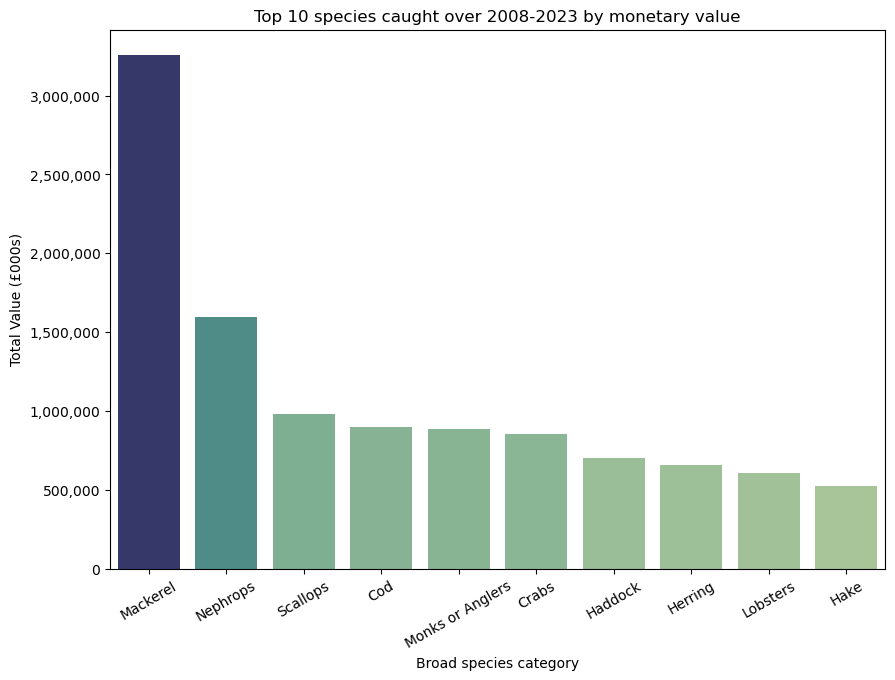

<Figure size 640x480 with 0 Axes>

In [8]:
# Set figure Size
fig = plt.figure(figsize =(10, 7))

# Create the plot, setting the colour to change as the value changes
ax = sns.barplot(top_10_species_value, x = 'species_broad', y = 'total_value_000s', hue = 'total_value_000s', palette = 'crest', legend = False)
ax.set(ylabel = 'Total Value (£000s)', xlabel = 'Broad species category',title = 'Top 10 species caught over 2008-2023 by monetary value')

# Format the y-axis values with commas and no scientific notation
y_vals = ax.get_yticks()  # Get the y-axis tick positions
ax.set_yticklabels(['{:,.0f}'.format(y) for y in y_vals])  # Format them with commas

# Show the plot
plt.xticks(rotation=30)  # Rotate x-axis labels for better readability
plt.show()

# Clear the plot
plt.clf()

Visualising the top 10 species in that plot format really helps to illuminate the stark difference between mackerel and the other species.  The next species on the top 10 list is nephrops (also known as langoustine).  From my previous job I know that the vast majority of these (if not all) are caught in Scottish waters.  So this leaves me excited to see what the comparison of countries will show us.  Interestingly, we know that the 'big five' key species that used to form the backbone of the UK fishing industry are cod, haddock, salmon, tuna and prawns, which supposedly make up 80% of our consumed seafood here in the UK.  

Salmon doesn't feature on this top 10 list, and that's likely because much of the salmon we consume now comes from aquaculture, which is a different beast and is recorded separately from wild caught fish as respresented by this dataset.  I was surprised to see monks and anglers in there, as I hadn't realised prior to this that it formed quite such a large portion of the monetry value.  I have a feeling that monkfish can attract a high price per weight, so after taking a look at weight, let's do up a scatter plot of price against weight.

In [9]:
# Create a dataframe of the sum and mean values per species for all years
allyears_agg_weight = all_data.groupby(['Species Broad'])['Landed Weight (tonnes)'].agg(['sum', 'mean']).reset_index()

# Rename columns for clarity
allyears_agg_weight.columns = 'species_broad', 'total_weight','average_weight'

# Sort the species by the total value landed
sorted_species_weight = allyears_agg_weight.sort_values(by = 'total_weight', ascending = False)

# Select the top 10 species
top_10_species_weight = sorted_species_weight.head(10)

top_10_species_weight

,species_broad,total_weight,average_weight
23,Mackerel,"3,410,714",128
18,Herring,"1,453,220",169
1,Blue Whiting,"769,437","2,224"
43,Scallops,"601,818",15
7,Crabs,"492,033",4
14,Haddock,"489,986",22
27,Nephrops,"325,927",7
5,Cod,"312,201",7
52,Whelks,"287,044",12
40,Saithe,"252,776",21


/var/folders/hl/n0654x5j7dd12gd927mvx03r0000gn/T/ipykernel_9481/789159186.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:,.0f}'.format(y) for y in y_vals])  # Format them with commas


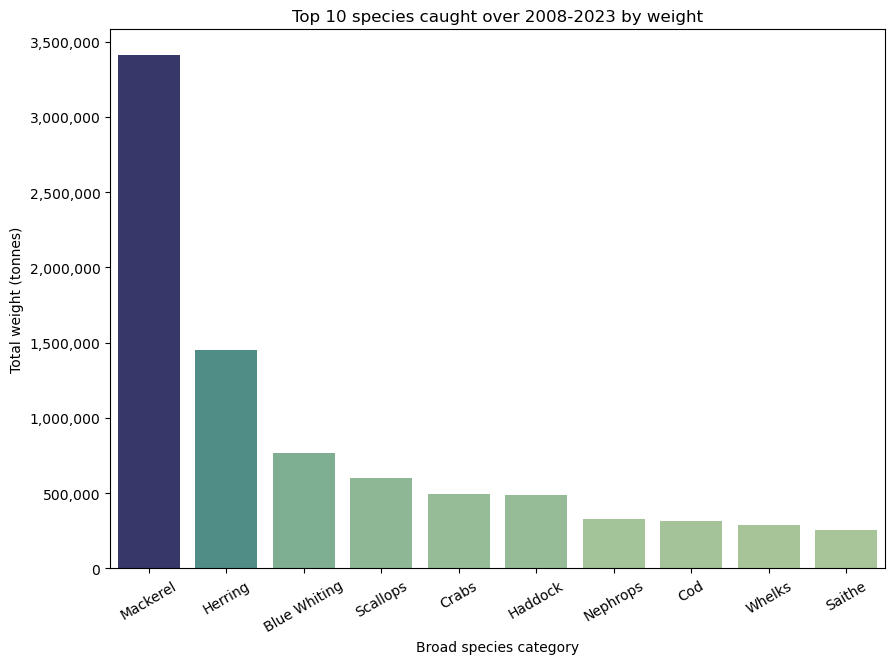

<Figure size 640x480 with 0 Axes>

In [10]:
# Set figure Size
fig = plt.figure(figsize =(10, 7))

# Create the plot, setting the colour to change as the value changes
ax = sns.barplot(top_10_species_weight, x = 'species_broad', y = 'total_weight', hue = 'total_weight', palette = 'crest', legend = False)
ax.set(ylabel = 'Total weight (tonnes)', xlabel = 'Broad species category',title = 'Top 10 species caught over 2008-2023 by weight')

# Format the y-axis values with commas and no scientific notation
y_vals = ax.get_yticks()  # Get the y-axis tick positions
ax.set_yticklabels(['{:,.0f}'.format(y) for y in y_vals])  # Format them with commas

# Show the plot
plt.xticks(rotation=30)  # Rotate x-axis labels for better readability
plt.show()

# Clear the plot
plt.clf()

Interesting, so again mackerel takes the number one spot by a long way, but the species in the top 10 list by weight are slightly different from those in the top 10 by monetary value.  To understand this better, I'm going to take a look at how the price per weight compares.

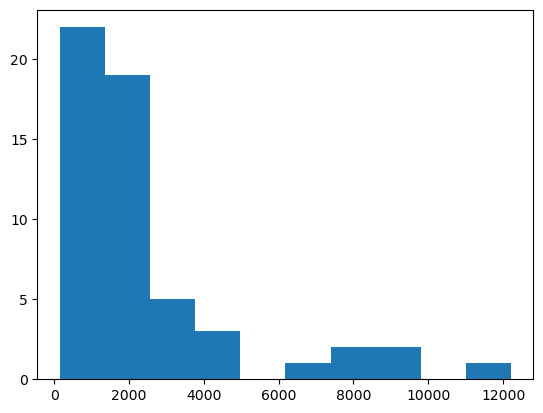

In [11]:
# First, let's merge the two dataframes that contain total and average weight and value for each species into one dataframe that containsi both
allyears_agg = allyears_agg_value.merge(allyears_agg_weight)

allyears_agg['price_per_tonne'] = allyears_agg['total_value'] / allyears_agg['total_weight']

plt.hist(allyears_agg.price_per_tonne)
plt.show()

/var/folders/hl/n0654x5j7dd12gd927mvx03r0000gn/T/ipykernel_9481/3930189239.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:,.0f}'.format(y) for y in y_vals])  # Format them with commas


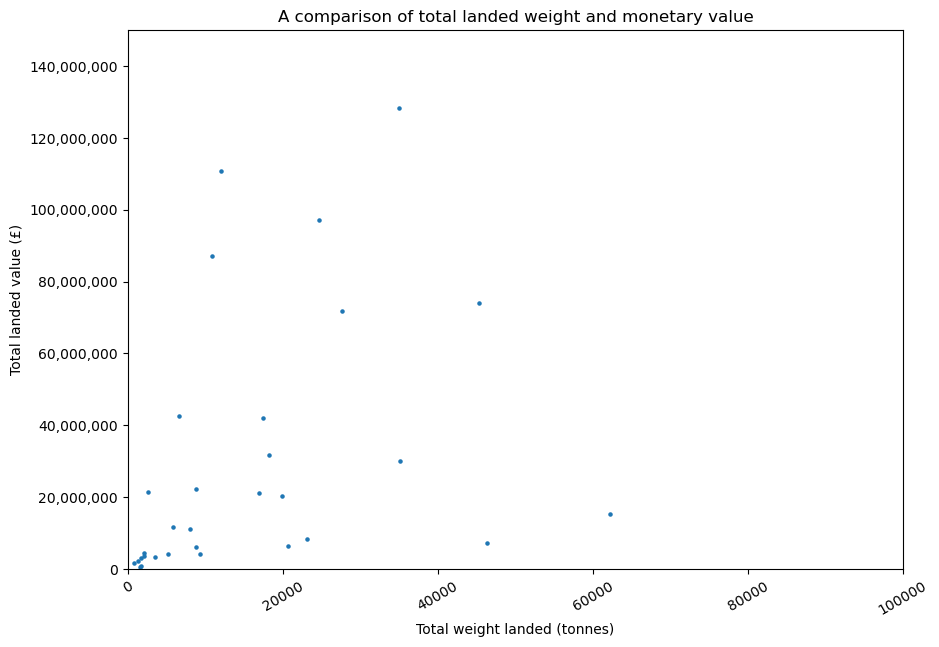

<Figure size 640x480 with 0 Axes>

In [12]:
# Set figure Size
fig = plt.figure(figsize =(10, 7))

# Create the plot, setting the colour to change as the value changes
ax = plt.subplot()
plt.scatter(allyears_agg_weight['total_weight'], allyears_agg['total_value'], s = 5)
plt.xlim(0,100000)
plt.ylim(0,150000000)
plt.xlabel('Total weight landed (tonnes)')
plt.ylabel('Total landed value (£)')
plt.title('A comparison of total landed weight and monetary value')

# Format the y-axis values with commas and no scientific notation
y_vals = ax.get_yticks()  # Get the y-axis tick positions
ax.set_yticklabels(['{:,.0f}'.format(y) for y in y_vals])  # Format them with commas

# Show the plot
plt.xticks(rotation=30)  # Rotate x-axis labels for better readability
plt.show()

# Clear the plot
plt.clf()

From this plot above, it looks like there's some correlation between total price and total weight landed.  I cropped the values that the plot showed as mackerel was so huge and such an outlier that it made it difficult to truly see what was going on at the smaller end of the scale.  To get an idea of correlation between weight and value, let's calculate the pearson correlation using the pearson function from scipy.stats.

In [13]:
corr_weight_value,p = pearsonr(allyears_agg_weight['total_weight'], allyears_agg['total_value'])
corr_weight_value

0.8558652892806462

In [14]:
# Filter the DataFrame to include only rows where 'Species Broad' is 'Mackerel'
mackerel_data = all_data.loc[all_data['Species Broad'] == 'Mackerel']

# Now group by 'Port of Landing' and calculate the sum and mean of 'Value (£)'
mackerel_by_port = mackerel_data.groupby(['Port of Landing'])['Value (£)'].agg(['sum', 'mean']).reset_index()

# Rename columns for clarity
mackerel_by_port.columns = ['port', 'total_value', 'average_value']

# Order by the value being landed into the port
mackerel_by_port_sorted = mackerel_by_port.sort_values(by = 'total_value', ascending = False)

# Select the top 10 ports, as I can see there are 442 with landings of mackerel
top_10_mackerel_ports = mackerel_by_port_sorted.head(10)

top_10_mackerel_ports

,port,total_value,average_value
292,Peterhead,"916,688,718","1,495,414"
221,Lerwick,"526,099,215","1,064,978"
126,Egersund,"266,807,813","4,940,885"
10,Alesund,"206,907,779","3,284,250"
349,Selje,"186,653,389","4,340,776"
188,Ijmuiden,"168,880,470","771,144"
129,Ellingsoy,"153,943,238","4,160,628"
177,Hirtshals,"135,295,706","3,979,285"
152,Fraserburgh,"98,566,182","314,908"
147,Floro,"90,142,255","2,048,688"


In [15]:

# Create a dataframe of the sum and mean values per species for each year
yearly_agg_value = all_data.groupby(['Year', 'Species Broad'])['Value (£)'].agg(['sum', 'mean']).reset_index()
yearly_agg_weight = all_data.groupby(['Year', 'Species Broad'])['Landed Weight (tonnes)'].agg(['sum', 'mean']).reset_index()

# Rename the columns for clarity
# yearly_agg_value.columns = ['year', 'species_broad', 'total_value', 'average_value']


In [16]:

# yearly_agg_value.pivot(columns = 'year', index = 'species_broad', values = 'total_value')

## Are there changes over time in the weights of species being landed?


## How do the values of £ per tonne vary over the study period?


## Which species are seeing the greatest decline and increase in landings over the study period?


## Sources and other useful information

### Fisheries data:
2008-2019: https://data.europa.eu/data/datasets/united-kingdom-fleet-landings-and-foreign-fleet-landings-into-the-uk-by-port-2011?locale=da

2020: https://www.gov.uk/government/statistics/uk-sea-fisheries-annual-statistics-report-2020 

2021: https://www.gov.uk/government/publications/uk-and-foreign-vessels-landings-by-uk-port-and-uk-vessel-landings-abroad-provisional-data

2022: https://www.gov.uk/government/publications/2022-uk-and-foreign-vessels-landings-by-uk-port-and-uk-vessel-landings-abroad-provisional-data

2023: https://www.gov.uk/government/publications/2023-uk-and-foreign-vessels-landings-by-uk-port-and-uk-vessel-landings-abroad-provisional-data


### Other interesting data:
* Effort statistics (MMO): https://www.gov.uk/government/statistical-data-sets/effort-statistics-august-2015
* Landings 1999-2003 (Eng, Wales and NI): https://webarchive.nationalarchives.gov.uk/ukgwa/20090617065827/https://statistics.defra.gov.uk/esg/publications/fishports/default.asp


### Links and references:
* "As early as 1863, complaints about the declining condition of demersal fish stocks (mainly nearshore) led to a Royal Commission of Enquiry into fisheries" from https://www.nature.com/articles/ncomms1013#:~:text=Throughout%20the%20118%2Dyear%20time,and%20in%201955%20landed%2091%25.
* Article on the 2024 sand eel fishing ban: https://www.rspb.org.uk/whats-happening/news/sandeel-campaign-success-in-england